# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [4]:
#Import all the required libraries
import  time
import  re
import  glob
from    time import sleep
import  pandas as pd
import  numpy as np
from    skimage import io
import  matplotlib.pyplot as plt
import  random
from    collections import Counter
from    tensorflow.keras.preprocessing.text import Tokenizer
from    tensorflow.keras.preprocessing.sequence import pad_sequences
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers,Model
from    tqdm import tqdm
from    nltk.translate.bleu_score import sentence_bleu
import  socket
import  pickle

from   Config import Config
import Util
import Logger
from   Communication import Client
from ImagesInfo import ImagesInfo
from TimeKeeper import TimeKeeper

Let's read the dataset

In [6]:
Logger.set_log_level(2)
tk = TimeKeeper()
cfg = Config(None)
client = Client(cfg)
imagesInfo = ImagesInfo(cfg)


In WSL
The total images present in the dataset: 128
The total images present in the dataset: 128
The total number of lines in the caption file: 641


In [10]:
max_tokenized_words = 10000

tokenizer = Tokenizer(num_words=max_tokenized_words+1,oov_token='<unknown>')
tokenizer.fit_on_texts(imagesInfo.annotations_word_list)


In [11]:
# Create word-to-index and index-to-word mappings.
VOCABULARY_SIZE = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(VOCABULARY_SIZE))


Vocabulary Size: 1096


In [12]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

MAX_SEQ_LENGTH = 25

cap_vector = imagesInfo.annotations_word_list
Y_encoded = tokenizer.texts_to_sequences(cap_vector)
cap_vector_encoded_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")



In [13]:
#write your code here
batch_size = 32
def read_image(image_path,label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.
    return image, label


split the data into train, validation and final test sets

In [15]:
from sklearn.model_selection import train_test_split

# split the data into train, validation and final test sets
img_train, final_img_test, cap_train, final_cap_test = train_test_split(imagesInfo.all_img_vector, cap_vector_encoded_padded, test_size=0.01, random_state=42)
img_train, img_test, cap_train, cap_test = train_test_split(img_train, cap_train, test_size=0.2, random_state=42)

total_training_images = len(img_train)
total_test_images = len(img_test)
total_final_testing_images = len(final_img_test)
print("Total Images for training=%d" % (total_training_images))
print("Total Images for testing (validation)=%d" % (total_test_images))
print("Total Images for final random testing=%d" % (total_final_testing_images))



Total Images for training=506
Total Images for testing (validation)=127
Total Images for final random testing=7


In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))
final_test_dataset = tf.data.Dataset.from_tensor_slices((final_img_test, final_cap_test))


In [19]:
train_dataset

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, 25)), types: (tf.float32, tf.int32)>

In [18]:
#write your code here
train_dataset = train_dataset.map(read_image)
train_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(read_image)
test_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

A utility function to display image retrieved from a dataset and its corresponding caption

In [20]:
# A utility function to display image retrieved from a dataset and its corresponding caption
def show_image_caption_from_dataset(image,label):
    plt.imshow(image)
    for x in label.numpy():
        if(x != 0):
            print(tokenizer.index_word[x], end =" ")


Check that the data retrieved from dataset is in correct format

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 299, 299, 3)
(32, 25)
<start> a full view of a nice and big city <end> 

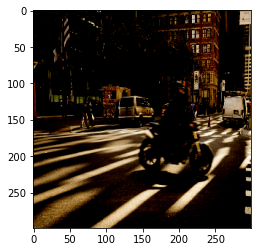

In [21]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
# (batch_size, 299, 299, 3)
print(sample_img_batch.shape) 
# (batch_size, max_len)
print(sample_cap_batch.shape) 
show_image_caption_from_dataset(sample_img_batch[0],sample_cap_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 299, 299, 3)
(32, 25)
<start> a young child brushing his teeth by himself <end> 

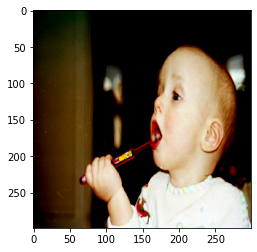

In [22]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
# (batch_size, 299, 299, 3)
print(sample_img_batch.shape) 
# (batch_size, max_len)
print(sample_cap_batch.shape) 
show_image_caption_from_dataset(sample_img_batch[1],sample_cap_batch[1])

In [23]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

# write code here to get the input of the image_model
new_input = image_model.input 
# write code here to get the output of the image_model
hidden_layer = image_model.output 

#build the final model using both input & output layer
image_features_extract_model = keras.Model(inputs=new_input, outputs=hidden_layer)

In [42]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [45]:
from tensorflow.keras import  losses
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [59]:
#write your code here
batch_size = 32
def my_read_image(image_path,label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.
    return image, image

ae_train_dataset = tf.data.Dataset.from_tensor_slices((img_train, img_train))
# ae_test_dataset = tf.data.Dataset.from_tensor_slices((img_test, img_test))
# ae_train_dataset = ae_train_dataset.shuffle(buffer_size=1024).batch(32)

ae_train_dataset = ae_train_dataset.map(my_read_image)
# ae_train_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
# ae_train_dataset = ae_train_dataset.batch(batch_size)
# ae_train_dataset = ae_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# print(type(ae_train_dataset))
# print(str(ae_train_dataset.shape()))

autoencoder.fit(ae_train_dataset,epochs=10)

Epoch 1/10


TypeError: 'NoneType' object is not callable

In [ ]:
# write your code to extract features from each image in the dataset
def extract_image_features(sample_img_batch):
    features = image_features_extract_model(sample_img_batch)
    features = tf.reshape(features, [sample_img_batch.shape[0],8*8, 2048])
    return features


In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
sample_img_batch = extract_image_features(sample_img_batch)
# (batch_size, 8*8, 2048)
print("sample_img_batch.shape after extract_image_features",sample_img_batch.shape)  
# (batch_size,40)
print("sample_cap_batch.shape after extract_image_features",sample_cap_batch.shape) 

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
sample_img_batch = extract_image_features(sample_img_batch)
# (batch_size, 8*8, 2048)
print("sample_img_batch.shape after extract_image_features",sample_img_batch.shape)  
# (batch_size,40)
print("sample_cap_batch.shape after extract_image_features",sample_cap_batch.shape) 

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = max_tokenized_words + 1
train_num_steps = total_training_images //batch_size #len(total train images) // BATCH_SIZE
test_num_steps = total_test_images //batch_size #len(total test images) // BATCH_SIZE

### Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        # build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
        return features    

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
from tensorflow.keras.activations import tanh
from tensorflow.keras.activations import softmax

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.units=units
        # build your Dense layer
        self.W1 = tf.keras.layers.Dense(units)
        # build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)
        # build your final Dense layer with unit 1
        # self.V = tf.keras.layers.Dense(1, activation='softmax')
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        score = self.V(score)
        attention_weights = softmax(score, axis=1)

        # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.reduce_mean(context_vector, axis=1)

        return context_vector, attention_weights        

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # iniitalise your Attention model with units
        self.attention = Attention_model(self.units)
        # build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        # build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        # build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate your input with the context vector from attention layer. 
        # Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. 
        # Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2])) 
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# @tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    img_tensor = extract_image_features(img_tensor)

    with tf.GradientTape() as tape:
        # Get the fixed length vector of Encoder-Decoder model
        features = encoder(img_tensor)
        # Loop through for max_length times
        for i in range(1, target.shape[1]):
            # Get predictions from the decoder
            # print("dec_input=%s features=%s hidden=%s" % (str(type(dec_input)), str(type(features)), str(type(hidden))))
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # Get the next target vector as dec_input
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
# @tf.function
def test_step(img_tensor, target):
    #write your code here to do the testing steps
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    img_tensor = extract_image_features(img_tensor)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    

    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_features_shape = 64
    attention_plot = np.zeros((MAX_SEQ_LENGTH, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(read_image(image,[])[0], 0) 
    # Extract features using our feature extraction model
    img_tensor_val = extract_image_features(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MAX_SEQ_LENGTH):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(tf.transpose(predictions))
        predicted_id = predicted_id.numpy()[0]
        # map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = 0): #your value for beam index):

    final_caption = "ToDo"
    #write your code to evaluate the result using beam search
                  
    return final_caption


In [ ]:
from PIL import Image
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot((len_cap//2)+1, (len_cap//2)+1, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
final_img_test[0]

In [ ]:
import time
rid = np.random.randint(0, total_final_testing_images)
test_image = final_img_test[rid]
# test_image = './Images/413231421_43833a11f5.jpg'
# test_image = '/content/drive/MyDrive/TestImages/3637013_c675de7705.jpg'

real_caption = final_cap_test[rid]
# real_caption = '<start> A couple stands close at the water edge <end>'
# real_caption = '<start> black dog is digging in the snow <end>'
real_caption = ' '.join([tokenizer.index_word[i] for i in final_cap_test[rid] if i not in [0]])

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

In [ ]:
# image_features_extract_model.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
# saving
with open('temp_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#decoder.save('MyModel',save_format='tf')
model_json = image_features_extract_model.to_json()
with open("temp_model/image_features_extract_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
image_features_extract_model.save_weights("temp_model/image_features_extract_model.h5")
print("Saved image_features_extract_model to disk")

decoder.save_weights("temp_model/decoder.h5")
encoder.save_weights("temp_model/encoder.h5")


In [ ]:
# loading
with open('temp_model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#Reading the model from JSON file
with open('temp_model/image_features_extract_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.load_weights('temp_model/image_features_extract_model.h5')


In [ ]:
decoder.load_weights("temp_model/decoder.h5")
encoder.load_weights("temp_model/encoder.h5")


In [ ]:
import time
test_image = './413231421_43833a11f5.jpg'
# test_image = '/content/drive/MyDrive/TestImages/3637013_c675de7705.jpg'

# real_caption = final_cap_test[rid]
real_caption = '<start> A couple stands close at the water edge <end>'
# real_caption = '<start> black dog is digging in the snow <end>'
# real_caption = ' '.join([tokenizer.index_word[i] for i in final_cap_test[rid] if i not in [0]])

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)